# ReAct

ReAct is a short-term for Reasoning + Acting - https://arxiv.org/pdf/2210.03629

> IMPORTANT:
> Before running this Python notebook, ensure you have followed the necessary steps in the README at the root of this repository to setup your development environment.

## Examples from Research Paper

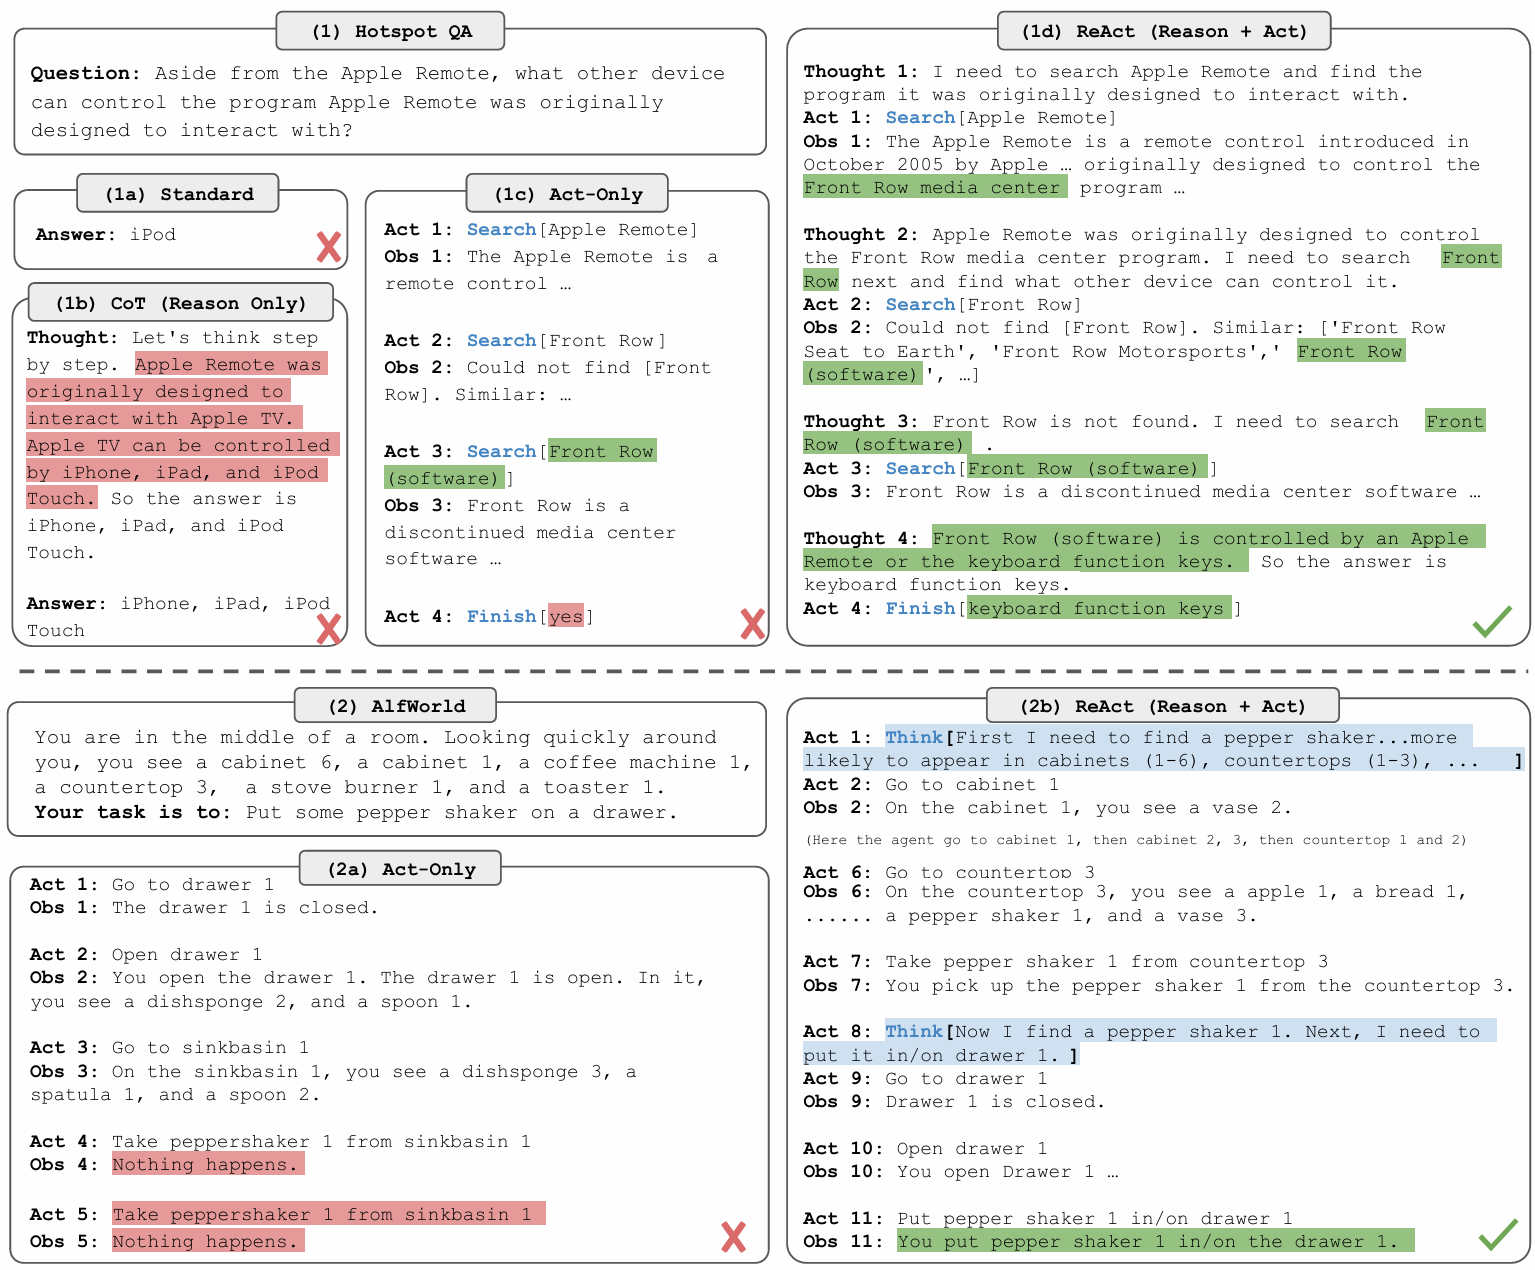

## Example flow in Demo

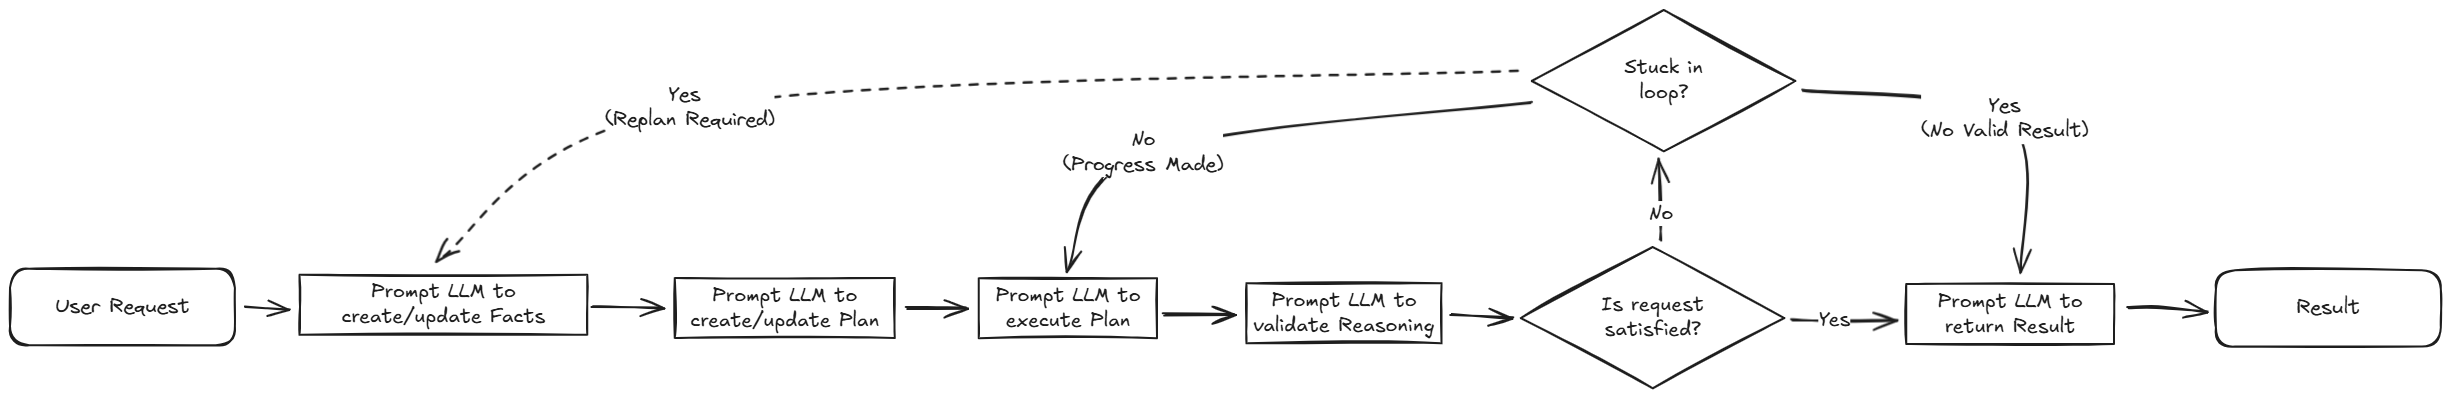

In [1]:
task = """I want to create a delicious vegan spaghetti bolognese based on the ingredients that I have available. I may need to purchase some more if there are any missing.

Provide me with a step-by-step recipe for the meal, and a shopping list of the items that I will need to purchase. The recipe should be easy to follow and include the quantities of each ingredient required.

Try to minimize the number of ingredients that I need to purchase, and make sure that the meal can serve at least 4 people.
"""

In [2]:
context = """
"""

In [3]:
import os
wdir = os.path.abspath('../')

In [4]:
from __future__ import annotations

import sys
sys.path.append(os.path.join(wdir, 'modules')) # Import local modules

from IPython.display import display, Markdown
from helpers.storage_helpers import create_text_file
from datetime import datetime
import json

from dotenv import dotenv_values
from openai import AzureOpenAI
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from openai.types.chat.chat_completion import ChatCompletionMessage
from openai.types.chat.chat_completion_user_message_param import ChatCompletionUserMessageParam
from helpers.request_models import RequestValidationModel
from helpers.app_settings import AppSettings

In [5]:
# Load environment variables
settings = AppSettings(dotenv_values(f"{wdir}/.env"))
prompt_path = os.path.join(wdir, 'ReAct')
execution_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Configure the default credential provider for Azure
credential = DefaultAzureCredential(
    exclude_workload_identity_credential=True,
    exclude_developer_cli_credential=True,
    exclude_environment_credential=True,
    exclude_managed_identity_credential=True,
    exclude_powershell_credential=True,
    exclude_shared_token_cache_credential=True,
    exclude_interactive_browser_credential=True
)

openai_token_provider = get_bearer_token_provider(credential, 'https://cognitiveservices.azure.com/.default')

openai_client = AzureOpenAI(
    azure_endpoint=settings.openai_endpoint,
    azure_ad_token_provider=openai_token_provider,
    api_version="2024-12-01-preview"
)

In [6]:
from helpers.recipe_agent import RecipeAgent

executor_agent = RecipeAgent(
    client=openai_client, 
    model_deployment=settings.gpt4o_model_deployment_name,
    embedding_model_deployment=settings.text_embedding_model_deployment_name
)

executor_agent_details = executor_agent.get_agent_details()

display(Markdown(f"""# Agent Details\n\n{executor_agent_details}"""))

# Agent Details

- Name: Recipe Agent
- Description: An agent that can help with cooking recipes.
- Skills:
  - find_ingredients_in_kitchen: Find the ingredients that are available in the kitchen.
  - find_recipes_by_description: Find a single recipe that best matches the given description.          Args:         - description: A description of the recipe the user is looking for.         - available_ingredients: An optional list of ingredients that the user has available.         - count: The number of recipes to return. Default is 1.
  - generate_shopping_list_from_recipe: Generate a shopping list based on the ingredients required for a recipe and the available ingredients in the kitchen.          Args:         - recipe_name: The name of the recipe to generate a shopping list for.         - available_ingredients: An optional list of ingredients that are available in the kitchen.
  - modify_recipe_if_not_vegan: Modifies a known recipe to make it vegan-friendly, if it contains meat or dairy products.          Args:         - recipe_name: The name of the recipe to modify.

# ReAct Prompts

## Gathering Facts

Collecting facts effectively grounds the model's reasoning in verified, recalled, and assumed knowledge based on the provided context. 

By retrieving context-specific facts, the model is less likely to generate irrelevant or fabricated information. Additionally, this reasoning trace makes it easier to understand and verify how the final answer was derived.

In [7]:
initial_fact_prompt = """Below I will present you with a user's request, and potential relevant context to help you solve it.

Based on the user's request, use the context to answer the following survey to the best of your ability.

Here is the user's request:

```
{task}
```

Here is the context:

=== Context Start ===

{context}

=== Context End ===

Here is the survey:

1. List any specific facts or figures that are GIVEN based on the request. It is possible that there are none.
2. List any facts that are recalled from memory, your knowledge, or well-reasoned assumptions, etc.

When answering this survey, keep in mind that facts will typically be specific details.
Provide as many facts as you can, even if they seem trivial or unimportant.
"""

## Planning

After gathering the necessary facts, by reasoning over the request and available capabilities, the model can breakdown a complex problem into smaller, manageable sub-tasks. This approach reduces the chances of error propagation and allows the model to focus on reaching an end goal more effectively through logical steps.

In [8]:
plan_prompt = """To address the user's request, we have assembled the following team of experts:

{team}

Based on the team available, and known and unknown facts, create a short bullet-point plan for how we will address the user's request.

Remember, there is no requirement to involve all team members in the plan. Some team members may not be relevant to the user's request.
"""

## Executing

As we make progress, the model can take the necessary actions defined in the plan to produce expected outcomes. By following the plan and executing the steps in a logical order, the model can ensure that the final answer is as correct and complete as possible.

In [9]:
execute_prompt = """We are working to address the following user request:

```
{task}
```

To answer this request, we have assembled the following team:

{team}

Here is the context to consider:

=== Context Start ===

{context}

=== Context End ===

Here are facts to consider:

{facts}

Here is the plan to follow as best as possible:

{plan}
"""

## Validating Plan Outcomes

As each step is executed in the plan, the model can validate the progress that we are making towards the final goal. This verification helps ensure that the plan is still sound, and that any discrepancies between the predicted and actual outcomes can be addressed early.

Any continuous loop in actions or outcomes can be used as indicators for self-correction and re-evaluation of the plan.

In [10]:
validate_prompt = """We are working on the following user request:

```
{task}
```

And we have assembled the following team:

{team}

To make progress on the request, please answer the following questions, including necessary reasoning:

- Has enough of the plan been executed to successfully complete the original user request? This includes the execution of planned tasks, and the provision of all requested information.
- Are we in a loop where we are repeating the same requests and/or getting the same responses? Loops can span multiple turns, and can include repeated actions.
- What is the next instruction or question to make progress on the request? Phrase as if speaking directly, and include any specific information required.
"""

## Updating Facts

When the model detects that its initial plan is not producing the expected outcome, it must replan by first updating the facts based on the new context. By updating facts, we are essentially refreshing the model's understanding of the problem, which can lead to a more accurate and effective plan. 

Any changes, new observations, and outdated/incorrect information will be reflected in the updated facts.

In [11]:
update_facts_prompt = """Below I will present you with a user's request, and potential relevant context in the chat history to help you solve it.

Based on the request, please update the fact sheet to include anything new we have learned that is relevant to the request.
Example edits can include, but are not limited to, adding new assumptions, moving assumptions to verified facts if appropriate, etc. 
Updates may be made to any section of the fact sheet, and more than one section of the fact sheet can be edited. 
This is a good time to update recalled facts, so please at least add or update one well-reasoned assumption.
Do not remove any facts unless you have enough information to confidently do so.

Here is the user's request:

```
{task}
```

Here is the original context:

=== Context Start ===

{context}

=== Context End ===

Here is the original fact sheet:

{facts}

Here is the survey:

1. List any specific facts or figures that are GIVEN based on the request. It is possible that there are none.
2. List any facts that are recalled from memory, your knowledge, or well-reasoned assumptions, etc.

When answering this survey, keep in mind that facts will typically be specific details.
Provide as many facts as you can, even if they seem trivial or unimportant.
"""

## Updating the Plan

After the facts have been updated, updating the plan based on the original user request ensures that the model's next steps remain tightly aligned with the user's intent while incorporating new observations. This iterative process of updating facts and plans allows the model to adapt to changing circumstances and improve its reasoning over time.

In [12]:
update_plan_prompt = """Please briefly explain what went wrong on this last run (the root cause of the failure), and then come up with a new plan that takes steps and/or includes hints to overcome prior challenges and avoids repeating the same mistakes. As before, the new plan should be concise and be expressed in bullet-point form, and consider the following team available:

{team}
"""

## Finalizing the Answer

Once we've cycled through rounds of gathering facts, reasoning, acting, and even replanning, producing a final result consolidates all of those iterative steps into a coherent answer.

Producing the final results demonstrates that the model has successfully navigated through the iterative loop of the ReAct pattern, confirming that the reasoning was aligned with the user's request, and that the actions taken were effective in reaching the desired outcome.

In [13]:
result_prompt = """We are working on the following user request:

```
{task}
```

We have completed the task.

The above messages contain the conversation that took place to complete the task.

Based on the information gathered, provide the final answer to the original request.
The answer should be phrased as if you were speaking to the user.
"""

# Process request

In [14]:
def call_openai(messages):
    completion = openai_client.chat.completions.create(
        model=settings.gpt4o_model_deployment_name,
        messages=messages,
        temperature=0.3,
        top_p=0.3,
    )
    return completion.choices[0].message

In [15]:
def validate_request(messages):
    completion = openai_client.beta.chat.completions.parse(
        model=settings.gpt4o_model_deployment_name,
        messages=messages,
        response_format=RequestValidationModel,
        temperature=0.1,
        top_p=0.1
    )
    return completion.choices[0].message

In [16]:
def save_message_history(messages):
    # DEBUG: Convert all of the messages to a JSON file
    messages_json = []

    for message in messages:    
        if message is None:
            continue
        
        if "role" in message:
            messages_json.append(message)   
        elif isinstance(message, ChatCompletionMessage) or isinstance(message, ChatCompletionUserMessageParam):
            messages_json.append({
                "role": message.role,
                "content": message.content
            })
            
    create_text_file(os.path.join(prompt_path, 'output', f"{executor_agent.__class__.__name__}_{execution_timestamp}_messages.json"), json.dumps(messages_json, indent=4)) 

In [17]:
execute_messages = []

In [18]:
# 1 - Gather Facts
planning_messages = [ChatCompletionUserMessageParam(role="user", content=initial_fact_prompt.format(task=task, context=context))]
fact_message = call_openai(planning_messages)
facts = fact_message.content
planning_messages.append(ChatCompletionMessage(role="assistant", content=fact_message.content))
    
# 2 - Develop Plan
planning_messages.append(ChatCompletionUserMessageParam(role="user", content=plan_prompt.format(team=executor_agent_details)))
plan_message = call_openai(planning_messages)
plan = plan_message.content

In [19]:
# 3 - Execute Plan
processing = True
stall_count = 0
stall_limit = 2
replan_count = 0
replan_limit = 2

execute_content = execute_prompt.format(task=task, team=executor_agent_details, context=context, facts=facts, plan=plan)
execute_messages = [ChatCompletionMessage(role="assistant", content=execute_content)]

display(Markdown(f"""# Plan\n\n{execute_content}"""))

# Plan

We are working to address the following user request:

```
I want to create a delicious vegan spaghetti bolognese based on the ingredients that I have available. I may need to purchase some more if there are any missing.

Provide me with a step-by-step recipe for the meal, and a shopping list of the items that I will need to purchase. The recipe should be easy to follow and include the quantities of each ingredient required.

Try to minimize the number of ingredients that I need to purchase, and make sure that the meal can serve at least 4 people.

```

To answer this request, we have assembled the following team:

- Name: Recipe Agent
- Description: An agent that can help with cooking recipes.
- Skills:
  - find_ingredients_in_kitchen: Find the ingredients that are available in the kitchen.
  - find_recipes_by_description: Find a single recipe that best matches the given description.          Args:         - description: A description of the recipe the user is looking for.         - available_ingredients: An optional list of ingredients that the user has available.         - count: The number of recipes to return. Default is 1.
  - generate_shopping_list_from_recipe: Generate a shopping list based on the ingredients required for a recipe and the available ingredients in the kitchen.          Args:         - recipe_name: The name of the recipe to generate a shopping list for.         - available_ingredients: An optional list of ingredients that are available in the kitchen.
  - modify_recipe_if_not_vegan: Modifies a known recipe to make it vegan-friendly, if it contains meat or dairy products.          Args:         - recipe_name: The name of the recipe to modify.

Here is the context to consider:

=== Context Start ===




=== Context End ===

Here are facts to consider:

### Survey:

#### 1. Specific facts or figures GIVEN based on the request:
- The user wants to create a vegan spaghetti bolognese.
- The recipe should serve at least 4 people.
- The user has some ingredients available but may need to purchase additional ones.
- The recipe should include step-by-step instructions and quantities for each ingredient.
- The shopping list should minimize the number of additional ingredients the user needs to buy.

#### 2. Facts recalled from memory, knowledge, or well-reasoned assumptions:
- Vegan spaghetti bolognese typically includes ingredients such as:
  - Spaghetti (or another pasta type).
  - A plant-based protein substitute (e.g., lentils, mushrooms, tofu, tempeh, or a store-bought vegan mince).
  - Tomatoes (e.g., canned diced tomatoes, tomato paste, or fresh tomatoes).
  - Aromatics like onion and garlic.
  - Vegetables such as carrots and celery are often used in bolognese for flavor and texture.
  - Herbs and spices like oregano, basil, thyme, bay leaves, salt, and pepper are common.
  - Olive oil or another cooking oil is typically used for sautéing.
  - Optional ingredients for added flavor: soy sauce, nutritional yeast, red wine (vegan), or vegetable broth.
- A standard serving size for pasta is approximately 75-100 grams per person, so for 4 people, 300-400 grams of spaghetti would be needed.
- Vegan recipes avoid animal-derived products like meat, dairy, and eggs.
- The user may already have some pantry staples (e.g., salt, pepper, oil, or dried herbs), but this is not explicitly stated in the request.
- The recipe should be simple and beginner-friendly, as no advanced cooking skills are mentioned in the request.

Here is the plan to follow as best as possible:

### Plan to Address the User's Request:

1. **Identify Available Ingredients**:
   - Use **Recipe Agent's `find_ingredients_in_kitchen`** skill to determine which ingredients the user already has in their kitchen.

2. **Find a Suitable Recipe**:
   - Use **Recipe Agent's `find_recipes_by_description`** skill to search for a vegan spaghetti bolognese recipe that matches the user's request. 
   - Provide the list of available ingredients (from Step 1) to ensure the recipe aligns with what the user already has.

3. **Generate a Shopping List**:
   - Use **Recipe Agent's `generate_shopping_list_from_recipe`** skill to create a shopping list for the selected recipe, based on the ingredients the user is missing.

4. **Deliver the Recipe and Shopping List**:
   - Provide the user with the step-by-step recipe (including quantities for each ingredient) and the shopping list for any additional items they need to purchase.

### Notes:
- The **`modify_recipe_if_not_vegan`** skill is not needed, as the user specifically requested a vegan recipe, and we will search for one directly.
- The plan minimizes unnecessary steps and focuses on efficiently addressing the user's request.


In [20]:
final_response = None

while processing:
    # 3.1 - Validate the current state of the task
    validate_context = validate_prompt.format(task=task, team=executor_agent_details)
    validate_messages = [m for m in execute_messages]
    validate_messages.append(ChatCompletionUserMessageParam(role="user", content=validate_context))
    
    current_state_message = validate_request(validate_messages)
    current_state = current_state_message.parsed
    
    display(Markdown(f"""# Validation\n\n{current_state.model_dump_json(indent=2)}"""))
    
    # 3.2 - Check if the task is completed
    if current_state.is_request_completed.answer:
        processing = False
        display(Markdown(f"""# Validation\n\nRequest Satisfied."""))
        break
    
    # 3.3 - Check if the task is stuck in a loop
    if current_state.is_in_loop.answer:
        stall_count += 1
        
        if stall_count >= stall_limit:
            replan_count += 1
            stall_count = 0
            
            if replan_count >= replan_limit:
                processing = False
                display(Markdown(f"""# Validation\n\nReplan Limit Reached. Terminating."""))
                break
            
            display(Markdown(f"""# Validation\n\nLoop Detected. Replanning."""))
            
            planning_messages = [m for m in execute_messages]
            
            # 3.3.1 - Update Facts
            planning_messages.append(ChatCompletionUserMessageParam(role="user", content=update_facts_prompt.format(task=task, context=context, facts=facts)))
            
            fact_message = call_openai(planning_messages)
            facts = fact_message.content
            
            planning_messages.append(fact_message)
            
            # 3.3.2 - Update Plan
            planning_messages.append(ChatCompletionUserMessageParam(role="user", content=update_plan_prompt.format(team=executor_agent_details)))
            
            plan_message = call_openai(planning_messages)
            plan = plan_message.content
            
            # 3.3.3 - Reset and Execute Updated Plan
            execute_content = execute_prompt.format(task=task, team=executor_agent_details, context=context, facts=facts, plan=plan)
            execute_messages = [ChatCompletionMessage(role="assistant", content=execute_content)]
            
            display(Markdown(f"""# Plan\n\nNew plan:\n{execute_content}"""))

    # 3.4 - Execute the Next Instruction
    instruction = current_state.next_instruction_or_question.reason + " " + current_state.next_instruction_or_question.answer
    execute_messages.append(ChatCompletionUserMessageParam(role="user", content=instruction))
    response_message = executor_agent.process_query(execute_messages)
    execute_messages.append(response_message)
    
    display(Markdown(f"""# Execute\n\n{response_message.content}"""))
    
# 4 - Finalize Answer
if final_response is None:
    execute_messages.append(ChatCompletionUserMessageParam(role="user", content=result_prompt.format(task=task)))
    final_response_message = call_openai(execute_messages)
    execute_messages.append(final_response_message)

    final_response = final_response_message.content
    
display(Markdown(f"""# Final\n\n{final_response}"""))

# Validation

{
  "is_request_completed": {
    "reason": "The user request has not been fully addressed yet as we have not provided the recipe or shopping list.",
    "answer": false
  },
  "is_in_loop": {
    "reason": "We are not repeating the same requests or responses; we are progressing through the plan.",
    "answer": false
  },
  "next_instruction_or_question": {
    "reason": "The next step is to identify the ingredients available in the user's kitchen to proceed with the recipe selection.",
    "answer": "Please provide the list of ingredients currently available in your kitchen."
  }
}

Executing 1 tool functions...
Executing tool function: find_ingredients_in_kitchen with arguments: {}


# Execute

Here are the ingredients currently available in your kitchen:

- 500g plain flour
- 200g caster sugar
- 500g cocoa powder
- 100g pasta
- 2 cans of tomatoes
- A broccoli head
- 1L maple syrup
- 200g light brown sugar
- 100g bicarbonate of soda
- 1kg walnuts
- 150ml vanilla extract
- 500g coconut oil
- 1kg oats
- 1kg raisins
- 500g dark chocolate
- 150g almonds

Next, I will find a vegan spaghetti bolognese recipe that incorporates as many of these ingredients as possible. Let me proceed!

# Validation

{
  "is_request_completed": {
    "reason": "The user request has not been fully addressed yet as the recipe and shopping list have not been provided.",
    "answer": false
  },
  "is_in_loop": {
    "reason": "We are making progress towards completing the request and are not repeating actions unnecessarily.",
    "answer": false
  },
  "next_instruction_or_question": {
    "reason": "The next step is to find a suitable recipe based on the user's available ingredients.",
    "answer": "Please find a vegan spaghetti bolognese recipe that matches the user's description and incorporates as many of the available ingredients as possible."
  }
}

Executing 1 tool functions...
Executing tool function: find_recipes_by_description with arguments: {'description': 'vegan spaghetti bolognese', 'available_ingredients': ['plain flour', 'caster sugar', 'cocoa powder', 'pasta', 'cans of tomatoes', 'broccoli', 'maple syrup', 'light brown sugar', 'bicarbonate of soda', 'walnuts', 'vanilla extract', 'coconut oil', 'oats', 'raisins', 'dark chocolate', 'almonds'], 'count': 1}


# Execute

I found a spaghetti bolognese recipe, but it is not vegan. It includes ingredients like ground beef and Parmesan cheese. I will modify this recipe to make it vegan-friendly and incorporate as many of your available ingredients as possible. Let me proceed!

# Validation

{
  "is_request_completed": {
    "reason": "The user request has not been fully addressed yet as the recipe and shopping list have not been provided.",
    "answer": false
  },
  "is_in_loop": {
    "reason": "We are not in a loop as each step is progressing towards fulfilling the user's request.",
    "answer": false
  },
  "next_instruction_or_question": {
    "reason": "The next step in the plan is to modify the identified recipe to make it vegan-friendly and align it with the user's available ingredients.",
    "answer": "Please proceed to modify the identified spaghetti bolognese recipe to make it vegan-friendly and incorporate as many of the user's available ingredients as possible."
  }
}

Executing 1 tool functions...
Executing tool function: modify_recipe_if_not_vegan with arguments: {'recipe_name': 'spaghetti bolognese'}


# Execute

I have modified the spaghetti bolognese recipe to make it vegan-friendly. Now, I will adjust it further to incorporate as many of your available ingredients as possible. Let me proceed!

# Validation

{
  "is_request_completed": {
    "reason": "The user request has not been fully addressed yet as the recipe and shopping list have not been finalized and provided.",
    "answer": false
  },
  "is_in_loop": {
    "reason": "We are not in a loop as each step is progressing towards completing the user's request.",
    "answer": false
  },
  "next_instruction_or_question": {
    "reason": "The next step is to finalize the vegan spaghetti bolognese recipe and generate the shopping list.",
    "answer": "Please finalize the vegan spaghetti bolognese recipe, incorporating the user's available ingredients, and generate the shopping list for any missing items."
  }
}

Executing 2 tool functions...
Executing tool function: find_recipes_by_description with arguments: {'description': 'vegan spaghetti bolognese', 'available_ingredients': ['plain flour', 'caster sugar', 'cocoa powder', 'pasta', 'cans of tomatoes', 'broccoli', 'maple syrup', 'light brown sugar', 'bicarbonate of soda', 'walnuts', 'vanilla extract', 'coconut oil', 'oats', 'raisins', 'dark chocolate', 'almonds'], 'count': 1}
Executing tool function: generate_shopping_list_from_recipe with arguments: {'recipe_name': 'vegan spaghetti bolognese', 'available_ingredients': ['plain flour', 'caster sugar', 'cocoa powder', 'pasta', 'cans of tomatoes', 'broccoli', 'maple syrup', 'light brown sugar', 'bicarbonate of soda', 'walnuts', 'vanilla extract', 'coconut oil', 'oats', 'raisins', 'dark chocolate', 'almonds']}


# Execute

Here is the finalized vegan spaghetti bolognese recipe, modified to incorporate your available ingredients as much as possible:

---

### Vegan Spaghetti Bolognese Recipe

#### Ingredients:
- **100g pasta** (available in your kitchen; serves 2, so additional pasta is needed for 4 servings)
- **2 cans of tomatoes** (available in your kitchen)
- **1 large onion**, finely chopped (missing)
- **3 cloves garlic**, minced (missing)
- **1 cup walnuts**, finely chopped (available in your kitchen; used as a plant-based protein substitute)
- **1 tsp dried oregano** (missing)
- **1 tsp dried basil** (missing)
- **Salt and pepper**, to taste (assumed missing)
- **2 tbsp coconut oil** (available in your kitchen; used for sautéing)
- **Optional: 100ml red wine** (missing, optional for flavor)

#### Steps:
1. Cook the pasta according to package instructions until al dente. Drain and set aside.
2. Heat coconut oil in a large pan over medium heat. Add the chopped onion and garlic, and sauté until soft and translucent.
3. Add the finely chopped walnuts to the pan and cook for 2-3 minutes, stirring frequently.
4. Stir in the canned tomatoes, oregano, and basil. Season with salt and pepper to taste.
5. Bring the sauce to a simmer and let it cook for 15-20 minutes, stirring occasionally.
6. Serve the sauce over the cooked pasta. Optionally, garnish with vegan Parmesan or nutritional yeast for added flavor.

---

### Shopping List:
To complete this recipe for 4 servings, you will need to purchase the following items:
1. **300g pasta** (to supplement the 100g you already have)
2. **1 large onion**
3. **3 cloves garlic**
4. **1 tsp dried oregano**
5. **1 tsp dried basil**
6. **Salt and pepper** (if not already available)

Optional:
- **100ml red wine** (for added flavor, if desired)

Let me know if you'd like further assistance!

# Validation

{
  "is_request_completed": {
    "reason": "The user has been provided with a finalized vegan spaghetti bolognese recipe and a shopping list for the missing ingredients.",
    "answer": true
  },
  "is_in_loop": {
    "reason": "The conversation has progressed logically without repeating the same requests or responses.",
    "answer": false
  },
  "next_instruction_or_question": {
    "reason": "The user has all the necessary information to proceed with their cooking.",
    "answer": "Please let me know if you need further assistance or clarification regarding the recipe or shopping list."
  }
}

# Validation

Request Satisfied.

# Final

Here’s your finalized vegan spaghetti bolognese recipe, tailored to use as many of your available ingredients as possible and serve 4 people. I’ve also included a shopping list for the missing items you’ll need to purchase.

---

### Vegan Spaghetti Bolognese Recipe (Serves 4)

#### Ingredients:
- **400g pasta** (you have 100g, so you’ll need to buy 300g more)
- **2 cans of tomatoes** (already available in your kitchen)
- **1 large onion**, finely chopped (you’ll need to purchase this)
- **3 cloves garlic**, minced (you’ll need to purchase this)
- **1 cup walnuts**, finely chopped (already available in your kitchen; used as a plant-based protein substitute)
- **1 tsp dried oregano** (you’ll need to purchase this)
- **1 tsp dried basil** (you’ll need to purchase this)
- **Salt and pepper**, to taste (you’ll need to purchase these if not already available)
- **2 tbsp coconut oil** (already available in your kitchen; used for sautéing)
- **Optional: 100ml red wine** (optional for added flavor, you can purchase this if desired)

---

#### Instructions:
1. **Cook the Pasta**: Bring a large pot of salted water to a boil. Add the pasta and cook according to the package instructions until al dente. Drain and set aside.

2. **Prepare the Sauce Base**: Heat 2 tablespoons of coconut oil in a large pan over medium heat. Add the chopped onion and garlic, and sauté for 5-7 minutes until soft and fragrant.

3. **Add the Walnuts**: Stir in the finely chopped walnuts and cook for 2-3 minutes, allowing them to toast slightly for added flavor.

4. **Add the Tomatoes and Seasoning**: Pour in the 2 cans of tomatoes, and add the oregano, basil, salt, and pepper. Stir well to combine.

5. **Simmer the Sauce**: Reduce the heat to low and let the sauce simmer for 15-20 minutes, stirring occasionally. If using red wine, add it at this stage for extra depth of flavor.

6. **Combine and Serve**: Serve the sauce over the cooked pasta. Optionally, garnish with vegan Parmesan or nutritional yeast if you have any on hand.

---

### Shopping List:
To complete this recipe, you’ll need to purchase the following items:
1. **300g pasta** (to supplement the 100g you already have)
2. **1 large onion**
3. **3 cloves garlic**
4. **1 tsp dried oregano**
5. **1 tsp dried basil**
6. **Salt and pepper** (if not already available)

Optional:
- **100ml red wine** (for added flavor, if desired)

---

This recipe is simple, delicious, and makes use of the ingredients you already have while keeping the shopping list minimal. Let me know if you have any questions or need further assistance! Enjoy your meal! 🌱🍝

In [21]:
# DEBUG: Save the final responses to a file
save_message_history(execute_messages)
create_text_file(os.path.join(prompt_path, 'output', f"{executor_agent.__class__.__name__}_{execution_timestamp}_response.md"), final_response)